In [11]:
import torch
import pyro
import pyro.infer
import numpy as np
import matplotlib.pyplot as plt

pyro.set_rng_seed(101)

Toy example - 1

Irá girar uma moeda, 0.5 cara e 0.5 coroa. Se cair cara, o jogador vai chutar a bola no gol, se cair coroa não irá chutar. Quando chuva, acerta o gol em 0.65 das vezes.

Moeda:
- cara = 0
- coroa = 1

Gol:
- acertar gol = 1
- errar gol = 0

Desejo calcular a probabilidade de que a moeda caiu cara dado que foi observado o gol utilizando o algoritmo de inferência Importance Sampling. Note que o valor real desta probabilidade é 1.0 pois se ocorreu o gol, o jogador chutou e o único caso em que o jogador chuta é se a moeda caiu cara.

In [3]:
def print_resul_jogo(tupla):
    if tupla[0] == 0:
        m = "cara"
    else:
        m = "coroa"
    if tupla[1] == 0:
        g = "não fez o gol."
    else:
        g = "fez o gol."
        
    print("A moeda caiu " + m + " e o jogador " + g)

def jogo_gol():
    moeda = pyro.sample("moeda", pyro.distributions.Bernoulli(0.5))
    if moeda == 0:
        p = 0.6
    else:
        p = 0
    gol = pyro.sample("gol", pyro.distributions.Bernoulli(p))
    
    return moeda, gol

print_resul_jogo(jogo_gol())

#vou tentar calcular a probabilidade P(moeda = cara| gol = acertou)
conditioned_gol = pyro.condition(jogo_gol, data = {"gol": torch.tensor(1.)})
posterior = pyro.infer.Importance(conditioned_gol, num_samples=1000)
marginal = pyro.infer.EmpiricalMarginal(posterior.run(), sites = 'moeda')
print("P(moeda = cara| gol = acerto) = ", 1 - marginal.mean.item())

A moeda caiu coroa e o jogador não fez o gol.
P(moeda = cara| gol = acerto) =  0.9999997838968682


Toy example - 2

Uma adaptação do modelo anterior para realizar um teste utilizando a distribuição Categorical. Lançamos uma moeda, se cair cara o jogador 1 irá jogar, se cair coroa o jogador 2 irá jogar. O jogo é advinhar o peso de um saquinho de areia e para cada jogador temos as situações: chutou peso abaixo, chutou peso correto, chutou peso acima.

Moeda: 
- cara = 0
- coroa = 1

Chute do peso:
- abaixo = 0
- correto = 1
- acima = 2

Devemos também listar as probabilidades para cada um dos jogadores.
Jogador 1:
- P(peso abaixo) = 0.30
- P(peso correto) = 0.20
- P(peso acima) = 0.50

Jogador 2:
- P(peso abaixo) = 0.5
- P(peso correto) = 0.4
- P(peso acima) = 0.1

Quero saber a probabilidade de que foi o jogador 2 que jogou dado que o chute do peso foi correto. O valor dessa probabilidade é 0.66.

In [4]:
def print_resultado_saco_areia(tupla):
    if tupla[0] == 0:
        m = 'cara'
    else:
        m = 'coroa'
    if tupla[1] == 0:
        g = 'abaixo'
    elif tupla[1] == 1:
        g = 'correto'
    else:
        g = 'acima'
    print('A moeda caiu ' + m + ' e o chute do peso do saco de areia foi ' + g + '.')
    
def saco_areia():
    moeda = pyro.sample('moeda2', pyro.distributions.Bernoulli(0.5))
    if moeda == 0: #jogador 1
        p = torch.tensor([0.3, 0.2, 0.5])
    else: #jogador 2
        p = torch.tensor([0.5, 0.4, 0.1])
    chute_peso = pyro.sample('chute-peso', pyro.distributions.Categorical(p))
    
    return moeda, chute_peso

print_resultado_saco_areia(saco_areia())

#O observado é que o chute foi correto, quero a probabilidade de foi o jogador 2
#P(cara = coroa| chute = correto)
conditioned_areia = pyro.condition(saco_areia, data = {"chute-peso":torch.tensor(1.0)})
posterior = pyro.infer.Importance(conditioned_areia, num_samples=1000)
marginal = pyro.infer.EmpiricalMarginal(posterior.run(), sites = "moeda2")
print('P(moeda = coroa| chute = correto) = ', marginal.mean.item())

A moeda caiu coroa e o chute do peso do saco de areia foi abaixo.
P(moeda = coroa| chute = correto) =  0.6824769377708435


Modelo HW1

Os valores das distribuições foram obtidos através dos dados utilizando uma rede bayesiana no R.
Temos as variáveis aleatórias:

Age:
- young = 0
- adult = 1
- old = 2

Sex:
- female = 0
- male = 1

Education:
- uni = 0
- high = 1

Residence:
- small = 0
- big = 1

Ocupation:
- self = 0
- emp = 1

Travel:
- train = 0
- other = 1
- car = 2

Probabilidades condicionais: (estão no código)

In [7]:
def print_resul_travel(tensor):
    s = 'homem' if tensor[0] == 1 else 'mulher'
    if tensor[1] == 0:
        a = 'young'
    elif tensor[1] == 1:
        a = 'adult'
    else:
        a = 'old'
    e = 'uni' if tensor[2] == 0 else 'high'
    r = 'small' if tensor[3] == 0 else 'big'
    o = 'self' if tensor[4] == 0 else 'emp'
    if tensor[5] == 0:
        t = 'train'
    elif tensor[5] == 1:
        t = 'other'
    else:
        t = 'car'
    print('Sex: ' + s + '| Age: ' + a + '| Education: ' + e + '| Residence: ' + r + '| Ocupation: ' + o + '| Travel: ' + t)
def model_travel():
    #valores de distribuição obtidos com o R    
    sex = pyro.sample('sex', pyro.distributions.Bernoulli(0.6))
    age = pyro.sample('age', pyro.distributions.Categorical(torch.tensor([0.32, 0.21, 0.47])))
    if sex == 0:
        if age == 0:
            p1 = torch.tensor([0.46, 0.54])
        elif age == 1:
            p1 = torch.tensor([0.36, 0.64])
        else:
            p1 = torch.tensor([0.15, 0.85])
    else:
        if age == 0:
            p1 = torch.tensor([0.2, 0.8])                            
        elif age == 1:
            p1 = torch.tensor([0.29, 0.71])
        else:
            p1 = torch.tensor([0.1, 0.9])
    education = pyro.sample('education', pyro.distributions.Categorical(p1))
    if education == 0:
        p2 = torch.tensor([0.07, 0.93])
    else:
        p2 = torch.tensor([0.02, 0.98])
    ocupation = pyro.sample('ocupation', pyro.distributions.Categorical(p2))
    
    if education == 0:
        p3 = torch.tensor([0.13, 0.87])
    else:
        p3 = torch.tensor([0.28, 0.72])
    residence = pyro.sample('residence', pyro.distributions.Categorical(p3))
    
    if residence == 0:
        if ocupation == 0:
            p4 = torch.tensor([0.02, 0.25, 0.73])
        else:
            p4 = torch.tensor([0.37, 0.08, 0.55])
    else:
        if ocupation == 0:
            p4 = torch.tensor([0.16, 0.16, 0.68])            
        else:
            p4 = torch.tensor([0.22, 0.2, 0.58])
    travel = pyro.sample('travel', pyro.distributions.Categorical(p4))
    
    return sex, age, education, ocupation, residence, travel
 
print_resul_travel(model_travel())


condition_model = pyro.condition(model_travel, data ={'ocupation':torch.tensor(0.0), 'residence':torch.tensor(1.0)})
posterior = pyro.infer.Importance(condition_model, num_samples=1000)
marginal = pyro.infer.EmpiricalMarginal(posterior.run(), sites = 'travel')
samples = np.array([marginal().item() for x in range(1000)])
_, val = np.unique(samples, return_counts=True)
print('Probabilidades da distribuição de travel dado ocupation = self e residence = big.')
print(val/1000)

Sex: homem| Age: adult| Education: high| Residence: big| Ocupation: emp| Travel: other
Probabilidades da distribuição de travel dado ocupation = self e residence = big.
[0.174 0.173 0.653]


Probabilidade marginal da idade:
[0.39  0.259 0.351]


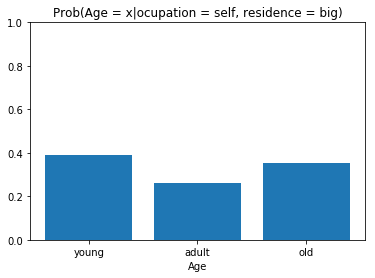

In [18]:
posterior = pyro.infer.Importance(condition_model, num_samples=1000)
marginal = pyro.infer.EmpiricalMarginal(posterior.run(), sites = 'age')
samples = np.array([marginal().item() for x in range(1000)])
_, val = np.unique(samples, return_counts=True)
print('Probabilidade marginal da idade:')
print(val/1000)
plt.bar(['young', 'adult', 'old'], val/1000)
plt.xlabel('Age')
plt.title('Prob(Age = x|ocupation = self, residence = big)')
plt.ylim([0, 1])
plt.show()

In [28]:
%%html
<img src = "causal_model.png"/>